# Coursera Capstone - Part 3 - Visualize

## Start off by importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install bs4 
!pip install lxml

#ALREADY INSTALLED FORGE USING ANACONDA PROMPT
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#ALREADY INSTALLED FOLIUM USING ANACONDA PROMPT
!conda install -c conda-forge folium=0.5.0 #--yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 102kB 1.0MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.8MB 1.1MB/s eta 0:00:01     |█▏                              | 215kB 1.1MB/s eta 0:00:05     |██████████████████              | 3.2MB 1.1MB/s eta 0:00:03
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.49         |             p

## Use Pandas and its features to read the target URL

In [2]:
#web scraping using pandas
#note: set header = 0 to use the first row as column headers
# !pip install lxml to correct import error when reading html, lxml was not found
#!pip install html5lib #bandaid for lxml
!conda install -c conda-forge lxml --yes #-c conda-forge geopy --yes 
!conda install -c conda-forge html5lib --yes #-c conda-forge geopy --yes 

d = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)

#Interesting notes about the pandas list of tables that's created from reading the URL
#type(d) #prints 'list'
#print(len(d)) #prints '3' since there are 3 tables on this page. the one we want to use is index=0
#print(d[0]) #
#format of df['column_name']['row_#_in_column_name']

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    lxml-4.4.0                 |   py36h7ec2d77_0         1.6 MB  conda-forge

The following packages will be UPDATED:

    lxml: 4.2.5-py37hefd8a0e_0 --> 4.4.0-py36h7ec2d77_0 conda-forge


lxml-4.4.0           | 1.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ cond

### Extract the table from the URL as a Pandas dataframe (note the shape and column names)

In [3]:
#set the target table to a 'dataframe'
df = d[0]

#check the shape of df
print(len(df)) #prints '289' is the # of rows (including the column name row)
print(df.shape) #prints '(289, 3)'
print(df.columns) #prints 'Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')'

288
(288, 3)
Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')


### Remove rows in the Borough column that are 'Not assigned' (and view the results)

In [4]:
#remove Postcodes that are "Not Assigned"
#df = df.drop(df[df.score < 50].index)
df_del_na = df.drop(df[df.Borough == 'Not assigned'].index)
df_del_na.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Set Neighborhood from 'Not assigned' to "Queen's Park" (and view the results)

In [5]:
#set Neighborhood from 'Not assigned' to "Queen's Park"
df_del_na.loc[df_del_na['Neighbourhood'] == "Not assigned", 'Neighbourhood'] = "Queen's Park"
df_del_na.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


### Rename column name from 'Neighbourhood' to 'Neighborhood'

In [6]:
df_del_na.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood': 'Neighborhood'}, inplace=True)
df_del_na.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### Flatten the table (for the rows in the Neighborhood columns)

In [7]:
#flatten groupby results by setting Neighborhood to list per row
df_del_na_grouped_flat = df_del_na.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda group_series: group_series.tolist()).reset_index()
print(df_del_na_grouped_flat.head(10), '\n', '\n')
print(df_del_na_grouped_flat.tail(10))

  PostalCode      Borough                                       Neighborhood
0        M1B  Scarborough                                   [Rouge, Malvern]
1        M1C  Scarborough           [Highland Creek, Rouge Hill, Port Union]
2        M1E  Scarborough                [Guildwood, Morningside, West Hill]
3        M1G  Scarborough                                           [Woburn]
4        M1H  Scarborough                                        [Cedarbrae]
5        M1J  Scarborough                              [Scarborough Village]
6        M1K  Scarborough      [East Birchmount Park, Ionview, Kennedy Park]
7        M1L  Scarborough                  [Clairlea, Golden Mile, Oakridge]
8        M1M  Scarborough  [Cliffcrest, Cliffside, Scarborough Village West]
9        M1N  Scarborough                      [Birch Cliff, Cliffside West] 
 

    PostalCode     Borough                                       Neighborhood
93         M9A   Etobicoke                                 [Islington A

### Read the csv into a pandas dataframe

In [8]:
geofile = pd.read_csv('https://cocl.us/Geospatial_data')

### Rename the Postal Code column to PostalCode

In [9]:
geofile.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)

### Merge the two dataframes

In [10]:
df_combined = pd.merge(df_del_na_grouped_flat, geofile, how='left', on='PostalCode')

### View the merged dataframe

In [11]:
df_combined.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"[Rouge, Malvern]",43.806686,-79.194353
1,M1C,Scarborough,"[Highland Creek, Rouge Hill, Port Union]",43.784535,-79.160497
2,M1E,Scarborough,"[Guildwood, Morningside, West Hill]",43.763573,-79.188711
3,M1G,Scarborough,[Woburn],43.770992,-79.216917
4,M1H,Scarborough,[Cedarbrae],43.773136,-79.239476


### Plot the Neighborhoods

In [12]:
#Use a starting latitude and longitude to help center the Toronto area map:
latitude = 43.72
longitude = -79.4
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11.5) # generate map centred around the Conrad Hotel

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_combined.Latitude, df_combined.Longitude, df_combined.PostalCode):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

#### Define Foursquare ID and Secret (hidden for GIT post)

In [13]:
CLIENT_ID = 'HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB' # your Foursquare ID
CLIENT_SECRET = 'UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HBIWSY1J1OXYRJV3GRFGMHIKD25MSPBZJSDBWVVQBEWM1YGB
CLIENT_SECRET:UBNOMB4NFKZWJU21DBEDHRHPFZEFNSPMK0RT2YFOV4DDN4BL


#### Define Foursquare Credentials and Version

In [14]:
def getNearbyVenues(postalcodes, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for postalcode, name, lat, lng in zip(postalcodes, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Use the function that explores nearby venues

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [15]:
# type your answer here

toronto_venues = getNearbyVenues(postalcodes=df_combined['PostalCode'],
                                 names=df_combined['Neighborhood'],
                                   latitudes=df_combined['Latitude'],
                                   longitudes=df_combined['Longitude']
                                  )



['Rouge', 'Malvern']
['Highland Creek', 'Rouge Hill', 'Port Union']
['Guildwood', 'Morningside', 'West Hill']
['Woburn']
['Cedarbrae']
['Scarborough Village']
['East Birchmount Park', 'Ionview', 'Kennedy Park']
['Clairlea', 'Golden Mile', 'Oakridge']
['Cliffcrest', 'Cliffside', 'Scarborough Village West']
['Birch Cliff', 'Cliffside West']
['Dorset Park', 'Scarborough Town Centre', 'Wexford Heights']
['Maryvale', 'Wexford']
['Agincourt']
['Clarks Corners', 'Sullivan', "Tam O'Shanter"]
['Agincourt North', "L'Amoreaux East", 'Milliken', 'Steeles East']
["L'Amoreaux West"]
['Upper Rouge']
['Hillcrest Village']
['Fairview', 'Henry Farm', 'Oriole']
['Bayview Village']
['Silver Hills', 'York Mills']
['Newtonbrook', 'Willowdale']
['Willowdale South']
['York Mills West']
['Willowdale West']
['Parkwoods']
['Don Mills North']
['Flemingdon Park', 'Don Mills South']
['Bathurst Manor', 'Downsview North', 'Wilson Heights']
['Northwood Park', 'York University']
['CFB Toronto', 'Downsview East']
['Down

In [16]:
toronto_venues.sample(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
451,M4M,[Studio District],43.659526,-79.340923,Delica Kitchen,43.660806,-79.341502,Café
1278,M5K,"[Design Exchange, Toronto Dominion Centre]",43.647177,-79.381576,Canoe,43.647452,-79.381320,Restaurant
1530,M5S,"[Harbord, University of Toronto]",43.662696,-79.400049,Rasa,43.662757,-79.403988,Restaurant
1976,M6J,"[Little Portugal, Trinity]",43.647927,-79.419750,The Garrison,43.649227,-79.422333,Music Venue
337,M4G,[Leaside],43.709060,-79.363452,Mucho Burrito Fresh Mexican Grill,43.706746,-79.361707,Mexican Restaurant
835,M5C,[St. James Town],43.651494,-79.375418,Crepe TO,43.650063,-79.374587,Creperie
534,M4T,"[Moore Park, Summerhill East]",43.689574,-79.383160,Loring-Wyle Parkette,43.690270,-79.383438,Park
1413,M5L,"[Commerce Court, Victoria Hotel]",43.648198,-79.379817,Hy's Steakhouse,43.649505,-79.382919,Steakhouse
491,M4R,[North Toronto West],43.715383,-79.405678,Gap,43.715450,-79.400089,Clothing Store
922,M5C,[St. James Town],43.651494,-79.375418,Bannock,43.652101,-79.381178,Restaurant


In [18]:
#export combined dataframe to excel (optional)
!conda install -c conda-forge openpyxl --yes #-c conda-forge geopy --yes 

toronto_venues.to_excel("toronto_venues.xlsx")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - openpyxl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    jdcal-1.4.1                |             py_0           9 KB  conda-forge
    openpyxl-2.6.2             |             py_0         152 KB  conda-forge
    et_xmlfile-1.0.1           |          py_1001          11 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         172 KB

The following packages will be UPDATED:

    et_xmlfile: 1.0.1-py37_0 --> 1.0.1-py_1001 conda-forge
    jdcal:      1.4-py37_0   --> 1.4.1-py_0    conda-forge

In [19]:
toronto_venues.shape

(2241, 8)

### Analyze the number of Venues per Postal Code

In [20]:
#sort counts descending (from largest to smallest)
toronto_venues.groupby(['PostalCode'])['Venue'].count().sort_values(ascending=False).head(20)

PostalCode
M5C    100
M5B    100
M5H    100
M5J    100
M5K    100
M5L    100
M5T    100
M5X    100
M5W     96
M5G     86
M4Y     84
M2J     65
M6J     63
M5E     57
M5A     49
M4X     43
M4K     42
M4M     41
M6S     37
M2N     37
Name: Venue, dtype: int64

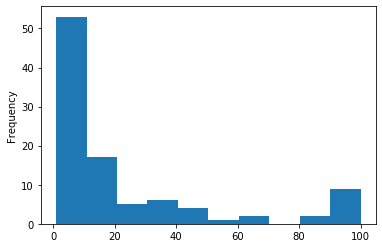

In [22]:
#plot the counts
toronto_venues.groupby(['PostalCode'])['Venue'].count().plot.hist()

### Plot the Venue counts

#### Create a boolean dataframe showing Postal Codes with Venue counts (>= 50 is True)

In [23]:
toronto_venues_50_df = pd.DataFrame((toronto_venues.groupby(['PostalCode'])['Venue'].count() >= 50))
toronto_venues_50_df #shows rows as boolean True/False

,Venue
PostalCode,
M1B,False
M1C,False
M1E,False
M1G,False
M1H,False
M1J,False
M1K,False
M1L,False
M1M,False


#### Rename Venue column to "Venue_bool50" to reflect boolean type

In [24]:
#set venue column to bool heading
toronto_venues_50_df.rename(columns = {'Venue': 'Venue_bool50'}, inplace=True)
toronto_venues_50_df                            

,Venue_bool50
PostalCode,
M1B,False
M1C,False
M1E,False
M1G,False
M1H,False
M1J,False
M1K,False
M1L,False
M1M,False


#### Create subset Postal Codes with Venue counts >= 50 (use later to filter toronto dataframe)

In [25]:
postalcodes_to_keep = toronto_venues_50_df[toronto_venues_50_df['Venue_bool50']==True].index
postalcodes_to_keep

Index(['M2J', 'M4Y', 'M5B', 'M5C', 'M5E', 'M5G', 'M5H', 'M5J', 'M5K', 'M5L',
       'M5T', 'M5W', 'M5X', 'M6J'],
      dtype='object', name='PostalCode')

##### NEXT STEPS: ADD COUNT ANALYSIS FROM DS0103EN-3-3-1
  1. maybe add .agg() function from PYCON (it creates a df)
  2. count recipes

#### Filter Toronto dataframe for Postal Codes that have Venue counts >=50

In [26]:
toronto_venues_50count = toronto_venues.loc[toronto_venues['PostalCode'].isin(postalcodes_to_keep)]
toronto_venues_50count.head(10)

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
92,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store
93,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,SilverCity Fairview Mall Cinemas,43.778681,-79.344085,Movie Theater
94,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,CF Fairview Mall,43.777994,-79.343665,Shopping Mall
95,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery
96,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Shoppers Drug Mart,43.778878,-79.344697,Pharmacy
97,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Hero Certified Burgers,43.777295,-79.344584,Burger Joint
98,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,DAVIDsTEA,43.777545,-79.345263,Tea Room
99,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Apple Fairview,43.777915,-79.343561,Electronics Store
100,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Purdys Chocolatier,43.778099,-79.343853,Candy Store
101,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Moxie's Classic Grill,43.777779,-79.343185,American Restaurant


In [27]:
toronto_venues_50count.shape

(1251, 8)

## *3. Analyze Each Postal Code / Neighborhood

#### Start with one hot encoding

In [28]:
# one hot encoding
toronto_venues_50count_onehot = pd.get_dummies(toronto_venues_50count[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#consider changing Neighborhood to postal code
toronto_venues_50count_onehot['PostalCode'] = toronto_venues_50count['PostalCode'] 

# move postal code / neighborhood column to the first column
fixed_columns = [toronto_venues_50count_onehot.columns[-1]] + list(toronto_venues_50count_onehot.columns[:-1])
toronto_venues_50count_onehot = toronto_venues_50count_onehot[fixed_columns]

toronto_venues_50count_onehot.head()

,PostalCode,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
92,M2J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
93,M2J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94,M2J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.

In [29]:
toronto_venues_50count_onehot.shape

(1251, 196)

#### Clusters pending

In [30]:
toronto_grouped = toronto_venues_50count_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped

,PostalCode,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M2J,0.000000,0.015385,0.000000,0.00,0.000000,0.000000,0.000000,0.015385,0.00,0.000000,0.030769,0.015385,0.000000,0.015385,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.015385,0.00,0.000000,0.000000,0.000000,0.00,0.015385,0.015385,0.015385,0.000000,0.00,0.015385,0.000000,0.000000,0.015385,0.000000,0.123077,0.000000,0.076923,0.00,0.00,0.000000,0.000000,0.000000,0.030769,0.000000,0.000000,0.000000,0.000000,0.015385,0.015385,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.015385,0.000000,0.00,0.000000,0.000000,0.076923,0.00,0.000000,0.000000,0.030769,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.015385,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015385,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.030769,0.000000,0.015385,0.000000,0.00,0.00,0.00,0.015385,0.000000,0.015385,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.015385,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.015385,0.000000,0.00,0.000000,0.000000,0

#### Let's confirm the new size

In [31]:
toronto_grouped.shape

(14, 196)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for pc in toronto_grouped['PostalCode']:
    print("----"+pc+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == pc].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M2J----
                  venue  freq
0        Clothing Store  0.12
1           Coffee Shop  0.08
2  Fast Food Restaurant  0.08
3         Women's Store  0.05
4        Cosmetics Shop  0.03


----M4Y----
                 venue  freq
0          Coffee Shop  0.07
1  Japanese Restaurant  0.06
2              Gay Bar  0.05
3     Sushi Restaurant  0.05
4           Restaurant  0.04


----M5B----
                       venue  freq
0                Coffee Shop  0.09
1             Clothing Store  0.06
2             Cosmetics Shop  0.04
3                       Café  0.03
4  Middle Eastern Restaurant  0.03


----M5C----
                venue  freq
0         Coffee Shop  0.07
1               Hotel  0.05
2                Café  0.05
3          Restaurant  0.05
4  Italian Restaurant  0.04


----M5E----
                venue  freq
0         Coffee Shop  0.11
1              Bakery  0.05
2        Cocktail Bar  0.05
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04


----M5G----
                ve

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postalcode_venues_sorted = pd.DataFrame(columns=columns)
postalcode_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    postalcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postalcode_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2J,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant
1,M4Y,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Pub,Men's Store,Mediterranean Restaurant,Gym,Fast Food Restaurant
2,M5B,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Bookstore,Lingerie Store
3,M5C,Coffee Shop,Hotel,Café,Restaurant,Italian Restaurant,Gastropub,Breakfast Spot,Clothing Store,Cocktail Bar,Cosmetics Shop
4,M5E,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Café,Beer Bar,Steakhouse,Seafood Restaurant,Farmers Market,French Restaurant


## *4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [35]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [36]:
# add clustering labels
postalcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_venues_50count

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(postalcode_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
92,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store,3,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant
93,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,SilverCity Fairview Mall Cinemas,43.778681,-79.344085,Movie Theater,3,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant
94,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,CF Fairview Mall,43.777994,-79.343665,Shopping Mall,3,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant
95,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery,3,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant
96,M2J,"[Fairview, Henry Farm, Oriole]",43.778517,-79.346556,Shoppers Drug Mart,43.778878,-79.344697,Pharmacy,3,Clothing Store,Fast Food Restaurant,Coffee Shop,Women's Store,Tea Room,Toy / Game Store,Food Court,Bakery,Cosmetics Shop,Japanese Restaurant


Finally, let's visualize the resulting clusters

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Latitude'

<a id='item5'></a>